<h1 style="text-align: center; font-size: 48px;">Projet Machine Learning for Trading : Analyse et Modélisation des Impacts des Annonces de la BCE (Monetary Policy Decisions) sur les taux historiques et les taux de change EUR/USD</h1>
<h2 style="text-align: center; font-size: 48px;">Étudiants : Roccaro Hugo & Assadi Mélodie</h2>
<h3 style="text-align: center; font-size: 48px;">Professeur : Champonnois Sylvain</h3>



# Introduction


Ce projet vise à étudier l’impact des annonces de politique monétaire de la Banque Centrale Européenne (BCE) sur les taux historiques de la BCE ainsi que sur les taux de change EUR/USD. Ces taux, souvent influencés par les décisions relatives aux taux directeurs, peuvent enregistrer des variations significatives en réponse à ces annonces. Pour cela, nous nous appuierons sur une **analyse de sentiment** réalisée à partir des comptes rendus officiels publiés par la BCE lors des annonces des nouveaux taux.

Dans un second temps, nous développerons plusieurs modèles de machine learning (ML) pour prédire les variations des taux en utilisant le score issu de l’analyse de sentiment, combiné à des données de marché, telles que les taux d’inflation et les taux d'intérêt de la BCE.

Pour atteindre cet objectif, nous suivrons les étapes suivantes :  
1. Identifier les dates clés des annonces de la BCE.  
2. Analyser les variations des taux en réponse aux discours de la BCE.  
3. Évaluer l’impact statistique des annonces sur les fluctuations des taux.  
4. Construire et comparer des modèles de prédiction basés sur des approches de machine learning.  

Cette démarche nous permettra de mieux comprendre :  
- Les interactions entre les décisions de la BCE et le marché des changes (forex).  
- La sensibilité des taux historiques et des taux de change aux annonces officielles de la BCE.  
- La pertinence des analyses de sentiment dans l’explication des réactions du marché.  


# 1. Configuration des Bibliothèques pour l'Analyse des Données

Dans un premier temps, nous vérifions que toutes les bibliothèques nécessaires à notre étude sont importées. Nous ajoutons également la bibliothèque `skfin`, une extension de `scikit-learn` dédiée aux applications financières, qui propose des outils de machine learning adaptés à l'analyse des données de marché.

⚠️ **Attention :**

**L'installation des dépendances peut entrer en conflit avec l'environnement Jupyter et nécessiter un redémarrage de la session.**



In [ ]:
import os

if not os.path.exists('skfin'):
    !git clone https://github.com/schampon/skfin.git
%cd skfin

!pip install -r requirements.txt
!pip install -e .

/content/skfin
Obtaining file:///content/skfin
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for skfin (pyproject.toml) ... done
  Created wheel for skfin: filename=skfin-0.1-0.editable-py3-none-any.whl size=3499 sha256=66f7ad9d0a2135eac072d4b72e222f6ca542b2647ffdd744389b78d8c03dbd56
  Stored in directory: /tmp/pip-ephem-wheel-cache-935xod0e/wheels/6c/23/c7/4bc59143378b0e7d1894c98638a4db3b6a15e263a662c617ea
Successfully built skfin
  Attempting uninstall: skfin
    Found existing installation: skfin 0.1
    Uninstalling skfin-0.1:
      Successfully uninstalled skfin-0.1


In [ ]:
import time
import requests
import re
import subprocess
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Chargement Automatisé des Annonces de la BCE via Selenium

### Particularité de la page web de la BCE

La page web de la Banque Centrale Européenne (BCE) présente une structure dynamique, contrairement à celle de la Réserve Fédérale Américaine (FED). Cela signifie que :

- **Contenu chargé dynamiquement** : Les annonces et documents sont chargés progressivement au fur et à mesure que l'utilisateur fait défiler la page. Cela empêche l'accès direct à tout le contenu via un fichier HTML statique.

- **Limitations des outils standards** : Les fonctions pré-construites, comme celles de la bibliothèque `skfin`, utilisées pour extraire des données de pages statiques, ne sont pas adaptées ici, car elles ne peuvent pas gérer le contenu chargé dynamiquement.


Pour contourner cette limitation, nous utilisons une technique appelée **"rolling scrolling"** (défilement progressif) via Selenium :

1. **Automatisation du défilement** : Selenium permet de simuler un utilisateur qui fait défiler la page vers le bas, ce qui déclenche le chargement des nouveaux éléments dynamiques.

2. **Récupération progressive des données** : À chaque étape du défilement, les nouveaux éléments sont détectés et collectés.

3. **Flexibilité** : Cette méthode nous permet d'extraire des informations d'une page web dynamique, tout en surmontant les restrictions liées à l'architecture du site de la BCE.

---

 Nous commençons par installer une version open-source de Chrome (Chromium) pour qu'elle puisse être utilisée avec Selenium :


In [ ]:
!apt-get update
!apt-get install -y chromium-browser
!pip install selenium

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

Avant de traiter les informations essentielles des annonces de la BCE, nous créons des **fonctions helpers** pour simplifier l’analyse des fichiers HTML. Ces outils permettent d’extraire les éléments clés, tels que les titres, les dates de publication et le contenu des annonces.

\
Pour télécharger plusieurs fichiers HTML en parallèle et surmonter les contraintes des notebooks Jupyter, nous nous appuyons sur des requêtes asynchrones et les bibliothèques suivantes :

- **aiohttp** : Optimise les requêtes HTTP avec un fonctionnement asynchrone.
- **asyncio** : Gère l’exécution parallèle de plusieurs tâches.
- **nest_asyncio** : Autorise l’utilisation de boucles asynchrones dans Colab, rendant l’environnement plus flexible.

Enfin, la bibliothèque **BeautifulSoup** est utilisée pour extraire et organiser les informations pertinentes des fichiers HTML collectés.

#### Détail des fonctions helpers :
1. **`extract_title`** :
   - Extrait le titre principal de l'annonce. Certaines pages du site de la BCE sont mal configurées, avec un titre divisé en deux parties. Cette fonction reconstitue le titre complet lorsqu'il est fragmenté.
   - Retourne le titre ou une indication si celui-ci est introuvable.

2. **`extract_body`** :
   - Repère les sections pertinentes contenant du texte (balises `<p>`).
   - Regroupe et concatène les paragraphes pour produire un contenu clair.
   - Retourne le texte extrait ou un message si aucun contenu n’est disponible.

3. **Fonction asynchrone `_fetch_title_and_body`** :
   - Télécharge une page HTML à partir d'une URL et l’analyse avec BeautifulSoup.
   - Utilise `extract_title` et `extract_body` pour récupérer les informations pertinentes.

4. **Fonction asynchrone `fetch_all_titles_and_bodies`** :
   - Télécharge simultanément plusieurs pages grâce à des tâches asynchrones (`asyncio.gather`).
   - Retourne une liste de tuples contenant les titres et contenus pour chaque URL.




In [ ]:
import aiohttp
import asyncio
import nest_asyncio
from bs4 import BeautifulSoup

# Apply nest_asyncio to allow async loops in Jupyter Notebook
nest_asyncio.apply()

def extract_title(soup):
    title_element = soup.title
    title_text = title_element.get_text(strip=True) if title_element else None
    subtitle = soup.find('h2', class_='ecb-pressContentSubtitle')

    if title_text.startswith("Account of the monetary policy meeting"):
        return f"{title_text} {subtitle.get_text(strip=True)}" if subtitle else title_text

    if title_text and subtitle:
        return subtitle.get_text(strip=True)

    return "Title not available"

def extract_body(soup):
    sections = soup.find_all('div', class_='section')

    # Filter only sections containing meaningful elements
    relevant_content = []
    for section in sections:
        paragraphs = section.find_all('p')
        if paragraphs:
            relevant_content.extend(
                p.get_text(separator=' ', strip=True) for p in paragraphs
            )
    return " ".join(relevant_content) if relevant_content else "Text not available"

async def _fetch_title_and_body(session, url, index):
    try:
        print(f"Fetching URL {index + 1}: {url}...")
        async with session.get(url, timeout=10) as response:
            if response.status != 200:
                print(f"HTTP Error {response.status} for URL {index + 1}: {url}")
                return "Title not available", "Text not available"

            html = await response.text()
            soup = BeautifulSoup(html, 'html.parser')

            title_text = extract_title(soup)
            body_text = extract_body(soup)

            return title_text, body_text

    except Exception as e:
        print(f"Error fetching URL {index + 1}: {url}. Details: {e}")
        return "Title not available", "Text not available"

async def fetch_all_titles_and_bodies(urls):
    async with aiohttp.ClientSession() as session:
        tasks = [
            _fetch_title_and_body(session, url, index)
            for index, url in enumerate(urls)
            ]
        return await asyncio.gather(*tasks)

Comme expliqué précédemment, le rolling scrolling permet de charger dynamiquement une page web de la BCE dans un navigateur automatisé, simulant un défilement progressif pour récupérer les liens des documents. Les URLs collectées servent ensuite à extraire les titres, textes et dates des annonces, qui sont organisés dans un DataFrame Pandas.

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

def get_ecb_urls(nb_steps=10, waiting_time=10):

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.binary_location = "/usr/bin/chromium-browser"

    driver = webdriver.Chrome(options=chrome_options)

    url = 'https://www.ecb.europa.eu/press/accounts/html/index.en.html'
    driver.get(url)
    time.sleep(3)

    # Scroll progressively to load all content
    for step in range(1, nb_steps + 1):
        scroll_position = int(driver.execute_script(
            f"return document.body.scrollHeight * {step} / {nb_steps}"))
        driver.execute_script(f"window.scrollTo(0, {scroll_position});")
        time.sleep(waiting_time)

    html_code = driver.page_source
    pattern = re.compile(r'/press/accounts/\d{4}[^"]*en.html')
    urls_ = pattern.findall(html_code)
    urls = [f"https://www.ecb.europa.eu{url}" for url in set(urls_)]

    return urls

def load_ecb_statements():

    urls = get_ecb_urls()
    results = asyncio.run(fetch_all_titles_and_bodies(urls))

    data = pd.DataFrame({"Url": urls})
    data['Title'], data['Text'] = zip(*results)

    dates = []
    for title in data['Title']:
        # Regex to find double day dates like "3-4 May 2023"
        match = re.search(r'\b(\d{1,2})-\d{1,2} (\w+) (\d{4})\b', title)
        if match:
            day, month, year = match.groups()
            date_str = f"{day} {month} {year}"
            try:
                dates.append(pd.to_datetime(date_str, format='%d %B %Y'))
            except ValueError:
                dates.append(None)
        else:
            dates.append(None)

    data['Date'] = dates

    return (
        data.dropna(subset=['Date'])
            .set_index('Date')
            .sort_index()
    )

Nous chargeons ici les annonces de la BCE extraites et traitées.Il est normal que cette fonction prenne 1 à 2 minutes pour charger tous les liens des discours de la bce.

In [ ]:
statements = load_ecb_statements()

Fetching URL 1: https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190404~edc605830b.en.html...
Fetching URL 2: https://www.ecb.europa.eu/press/accounts/2017/html/ecb.mg171123.en.html...
Fetching URL 3: https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg221124~3527764024.en.html...
Fetching URL 4: https://www.ecb.europa.eu/press/accounts/2019/html/ecb.mg190523~3e19e27fb7.en.html...
Fetching URL 5: https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg201126~20e838e857.en.html...
Fetching URL 6: https://www.ecb.europa.eu/press/accounts/2020/html/ecb.mg200820~c30e2e26b9.en.html...
Fetching URL 7: https://www.ecb.europa.eu/press/accounts/2021/html/ecb.mg210408~46b9deaa4a.en.html...
Fetching URL 8: https://www.ecb.europa.eu/press/accounts/2016/html/mg160114.en.html...
Fetching URL 9: https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240222~1af5fcd5f9.en.html...
Fetching URL 10: https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg220519~c9200dba08.en.html...
Fetch

Avant de procéder à l'analyse des données, nous nous assurons que l'extraction des annonces de la BCE a bien été réalisée.

In [ ]:
statements.head()

,Url,Title,Text
Date,,,
2015-03-04,https://www.ecb.europa.eu/press/accounts/2015/...,Account of the monetary policy meeting of the ...,Mr Cœuré reviewed recent financial market deve...
2015-04-14,https://www.ecb.europa.eu/press/accounts/2015/...,Account of the monetary policy meeting of the ...,Mr Cœuré reviewed recent financial market deve...
2015-06-02,https://www.ecb.europa.eu/press/accounts/2015/...,Account of the monetary policy meeting of the ...,Mr Cœuré reviewed recent financial market deve...
2015-07-15,https://www.ecb.europa.eu/press/accounts/2015/...,Account of the monetary policy meeting of the ...,Mr Cœuré reviewed recent financial market deve...
2015-09-02,https://www.ecb.europa.eu/press/accounts/2015/...,Account of the monetary policy meeting of the ...,Mr Cœuré reviewed recent financial market deve...


In [ ]:
rows, cols = statements.shape
is_title_not_available = (statements['Title'] == "Title not available").any()
print(f"The DataFrame has {rows} rows and {cols} columns.")
print(f"\n'Title not available' exists: {is_title_not_available}.")

The DataFrame has 76 rows and 3 columns.

'Title not available' exists: False.


In [ ]:
url_test = statements['Url'].iloc[0]
title_test = statements['Title'].iloc[0]
text_test = statements['Text'].iloc[0]

print(f"URL: {url_test}\n")
print(f"Title: {title_test}\n")
print(f"Text:\n{text_test}\n")

URL: https://www.ecb.europa.eu/press/accounts/2015/html/mg150402.en.html

Title: Account of the monetary policy meeting of the Governing Council of the European Central Bank held in Nicosia on Wednesday and Thursday, 4-5 March 2015

Text:
Mr Cœuré reviewed recent financial market developments. Since the Governing Council’s previous monetary policy meeting on 21-22 January 2015, the announcement of the ECB’s expanded asset purchase programme (APP) had had a significant impact on euro area financial markets, contributing to lower government bond yields and money market rates, particularly at longer maturities, while the euro had depreciated further against the US dollar especially in the days leading up to the meeting. With the decision to expand the APP, augmenting the existing private sector asset purchase programmes with a public sector purchase programme (PSPP), euro area government bond yields had continued to trend lower, declining to all-time lows in most jurisdictions, with more 

# 3. Analyse de sentiment à partir des annonces de la BCE

Dans un premier temps, nous chargeons le dictionnaire de Loughran-McDonald, qui sert de référence pour notre analyse de sentiment, puis nous calculons le score correspondant à nos annonces BCE :

In [ ]:
from skfin.datasets import load_loughran_mcdonald_dictionary
from skfin.plot import line

lm = load_loughran_mcdonald_dictionary()
lm

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X = statements["Text"]

funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}


def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

In [ ]:
from skfin.text import coefs_plot, show_text

# Creation of the McDonald-Loughran lexicon as discussed in class
lm_lexica = {
    "negative": pd.Series(1, lm.loc[lm.Negative > 0].Word.str.lower().values),
    "positive": pd.Series(1, lm.loc[lm.Positive > 0].Word.str.lower().values),
}

# Dates to select
dates_to_select = ["2015-07-15", "2015-06-02", "2024-04-10"]
dates_to_select = [date for date in dates_to_select if date in statements.index]
filtered_statements = statements.loc[dates_to_select]

show_text(filtered_statements, lexica=lm_lexica, n=None, text_column="Text")

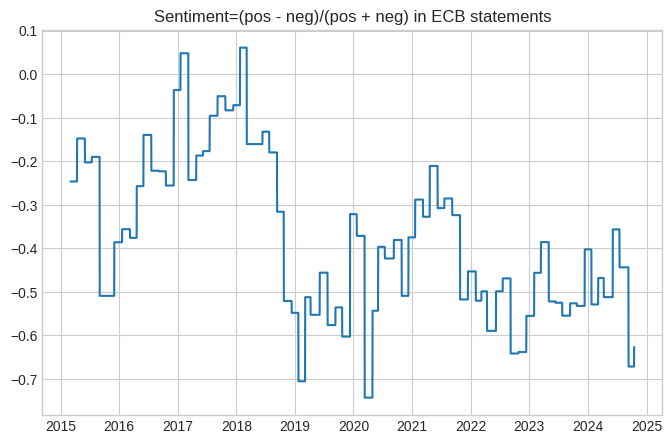

In [ ]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in ECB statements",
)

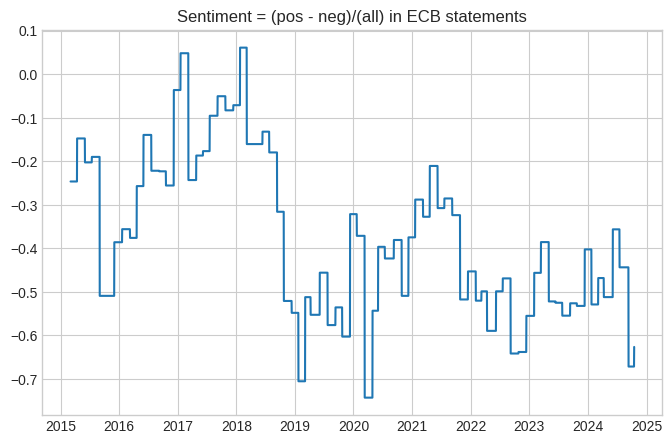

In [ ]:
line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment = (pos - neg)/(all) in ECB statements",
)

On observe un **sentiment score** globalement négatif sur toute la période étudiée. Deux tendances principales se dégagent : une phase "moins négative" entre mi-2015 et mi-2018, suivie d'une période de sentiment très négatif de 2019 à 2024, avec un léger rebond pendant la période COVID.

Un **sentiment score** négatif reflète une perception pessimiste des discours de la BCE. Cependant, l'évolution des taux obligataires dépend de trois facteurs principaux :

1. **Le contenu des discours** :  
   - Si la BCE adopte une posture accommodante pour soutenir l'économie (*dovish*), les taux ont tendance à baisser.  
   - En revanche, si le pessimisme découle de tensions inflationnistes, la BCE peut maintenir ou augmenter les taux (*hawkish*).

2. **Les actions concrètes de la BCE** : Les décisions directes de politique monétaire, comme une baisse ou une hausse des taux directeurs, influencent directement les marchés.

3. **Les anticipations des marchés** :  
   Les taux reflètent non seulement les discours actuels, mais aussi les attentes des investisseurs sur l'avenir. Un sentiment négatif peut déjà être intégré dans les prix (*pricé*), entraînant une réaction limitée ou différente sur les marchés.

Ainsi, un **sentiment score** négatif peut conduire à une baisse ou une hausse des taux, selon que la BCE privilégie le soutien économique (baisse des taux) ou la lutte contre l'inflation (hausse des taux). L’impact final dépend de la combinaison entre les discours, les actions réelles de la BCE et les anticipations des marchés.


# 4. Analyse des taux historiques de la BCE


In [ ]:
from io import StringIO

url = "https://sdw-wsrest.ecb.europa.eu/service/data/FM/D.U2.EUR.4F.KR.MRR_RT.LEV?format=csvdata"

response = requests.get(url)

if response.status_code == 200:
    # Parse the CSV data from the response
    csv_data = StringIO(response.text)
    df_historical_rate = pd.read_csv(csv_data, sep=",", encoding="utf-8")

    df_historical_rate = df_historical_rate[['TIME_PERIOD', 'OBS_VALUE']]
    df_historical_rate.columns = ['Date', 'Rate']
    df_historical_rate = df_historical_rate.dropna(subset=['Date', 'Rate'])
    df_historical_rate['Date'] = pd.to_datetime(df_historical_rate['Date'], errors='coerce')
else:
    print(f"Error fetching data. Status code: {response.status_code}")


In [ ]:
print("Descriptive Statistics of Historical Rates:")
df_historical_rate['Rate'].describe()

Descriptive Statistics of Historical Rates:


,Rate
count,9486.000000
mean,1.718390
std,1.594374
min,0.000000
25%,0.050000
50%,1.250000
75%,3.250000
max,4.750000


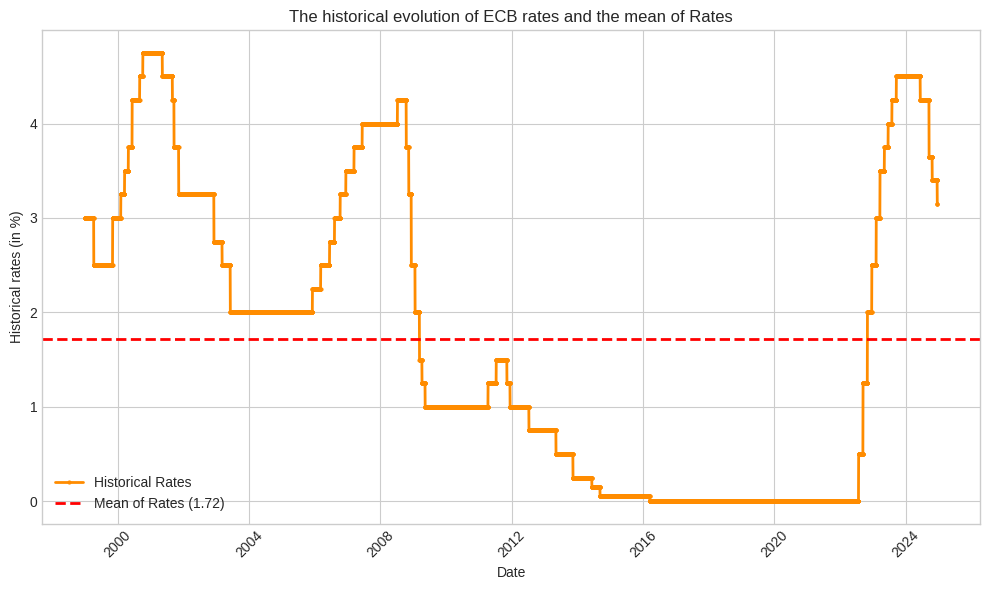

In [ ]:
mean_rate = df_historical_rate['Rate'].mean()

plt.figure(figsize=(10, 6))
plt.plot(df_historical_rate['Date'], df_historical_rate['Rate'], label="Historical Rates", color='darkorange',linewidth=2, marker='.', markersize=4)
plt.axhline(mean_rate, color='red', linestyle='--', linewidth=2, label=f"Mean of Rates ({mean_rate:.2f})")

plt.title("The historical evolution of ECB rates and the mean of Rates")
plt.xlabel("Date")
plt.ylabel("Historical rates (in %)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Pour mieux analyser les périodes de grande crise, nous avons restreint le graphique à la période 2007-2010. Ce choix permet de mettre en évidence les variations significatives des taux pendant la crise financière mondiale et de mieux comprendre les réponses des banques centrales face à cet événement.

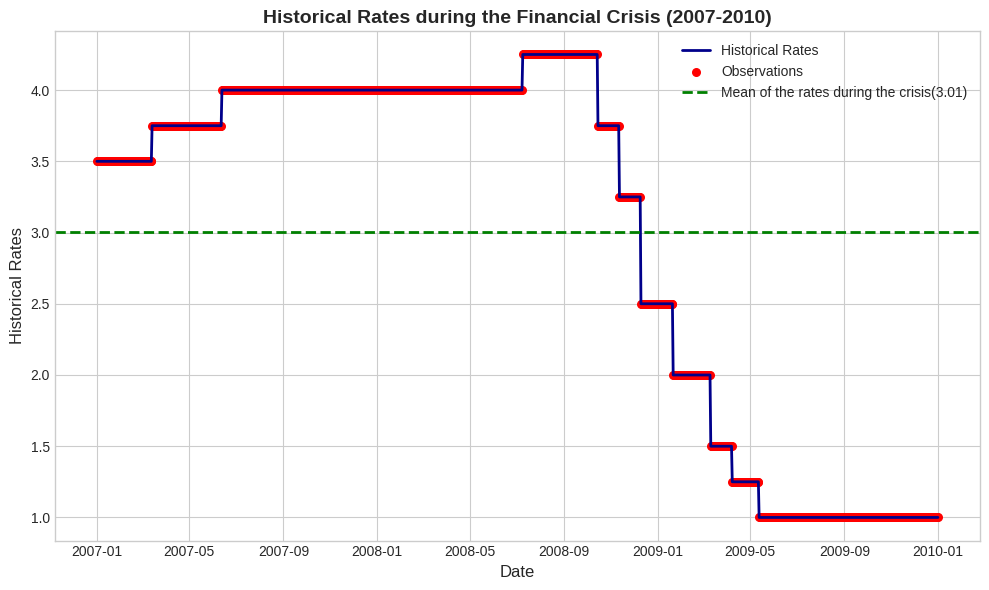

In [ ]:
crisis_period = df_historical_rate[(df_historical_rate['Date'] >= '2007-01-01') & (df_historical_rate['Date'] <= '2010-01-01')]

plt.figure(figsize=(10, 6))
plt.plot(crisis_period['Date'], crisis_period['Rate'], color='darkblue', linewidth=2, label="Historical Rates")

plt.scatter(crisis_period['Date'], crisis_period['Rate'], color='red', s=30, label="Observations")

mean_crise = crisis_period['Rate'].mean()
plt.axhline(mean_crise, color='green', linestyle='--', linewidth=2, label=f"Mean of the rates during the crisis({mean_crise:.2f})")

plt.title("Historical Rates during the Financial Crisis (2007-2010)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Historical Rates", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

On remarque plusieurs phases dans l'évolution des taux :

- **Avant la crise (2007-2008)** : Les taux étaient relativement élevés, autour de 4 %. Cette période reflète une politique monétaire stricte menée par les banques centrales pour maîtriser l'inflation dans un contexte économique globalement stable. Les niveaux élevés des taux témoignent d'une volonté de freiner la surchauffe économique et de préserver le pouvoir d'achat.

- **Pendant la crise (fin 2008)** : Les taux chutent brutalement, marquant une réponse rapide et coordonnée des banques centrales face à l'effondrement financier mondial. Cette baisse vise à réduire le coût du crédit, facilitant ainsi l'accès aux emprunts pour les ménages et les entreprises. L'objectif principal était de stimuler la **consommation** et l’**investissement**, tout en atténuant les conséquences économiques de la crise.

- **Niveaux bas (2009-2010)** : Les taux restent à des niveaux historiquement bas pendant plusieurs années. Cette période illustre une reprise économique lente et fragile, nécessitant une politique monétaire extrêmement accommodante pour soutenir la croissance. Les banques centrales ont maintenu cette stratégie pour éviter une rechute dans une récession prolongée.

\
Avant d’examiner l’impact des discours de la BCE sur les taux historiques, il est nécessaire de filtrer les données pour ne conserver que celles à partir de 2015. Cela correspond à la période pour laquelle les discours de la BCE sont disponibles, permettant ainsi une analyse cohérente entre les deux séries de données.


In [ ]:
df_historical_rate_filtered = df_historical_rate[df_historical_rate['Date'] >= '2015-01-01'].copy()
df_historical_rate_filtered.reset_index(drop=True, inplace=True)

sentiment_score = (lm_counts["positive"] - lm_counts["negative"]) / lm_counts["all"]
statements["Sentiment Score"] = sentiment_score

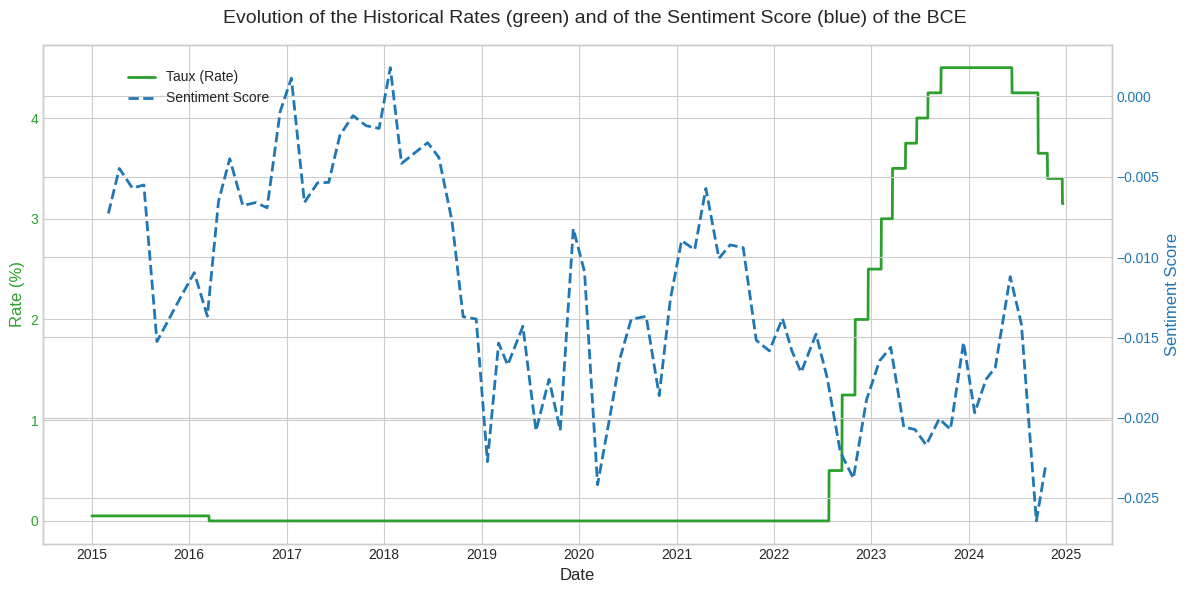

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_historical_rate_filtered['Date'], df_historical_rate_filtered['Rate'], color='tab:green', label='Taux (Rate)', linewidth=2)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Rate (%)", color='tab:green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:green')

ax2 = ax1.twinx()
ax2.plot(statements.index, statements["Sentiment Score"], color='tab:blue', label='Sentiment Score', linewidth=2, linestyle='--')
ax2.set_ylabel("Sentiment Score", color='tab:blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.suptitle("Evolution of the Historical Rates (green) and of the Sentiment Score (blue) of the BCE", fontsize=14)
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()

À partir de 2022, une forte hausse des taux (ligne verte) est observée, probablement en réponse aux pressions inflationnistes. Pendant ce temps, le sentiment score (ligne bleue) reste négatif, reflétant une perception prudente des discours de la BCE. Les variations du sentiment score semblent précéder légèrement les mouvements des taux, ce qui pourrait indiquer une anticipation des actions de la BCE par les marchés. Avant 2022, les taux sont restés proches de 0 %, alors que le sentiment score a montré des fluctuations plus marquées. Après le pic des taux en 2023, le sentiment score chute à nouveau, ce qui pourrait refléter une décorrélation entre la communication de la BCE et ses actions sur les taux.

Nous allons donc focaliser notre analyse sur les taux à partir de 2022, car avant cette période, les taux restent relativement constants. Pour approfondir cette étude, une heatmap sera utilisée afin de mieux visualiser l’impact des discours de la BCE sur les taux.

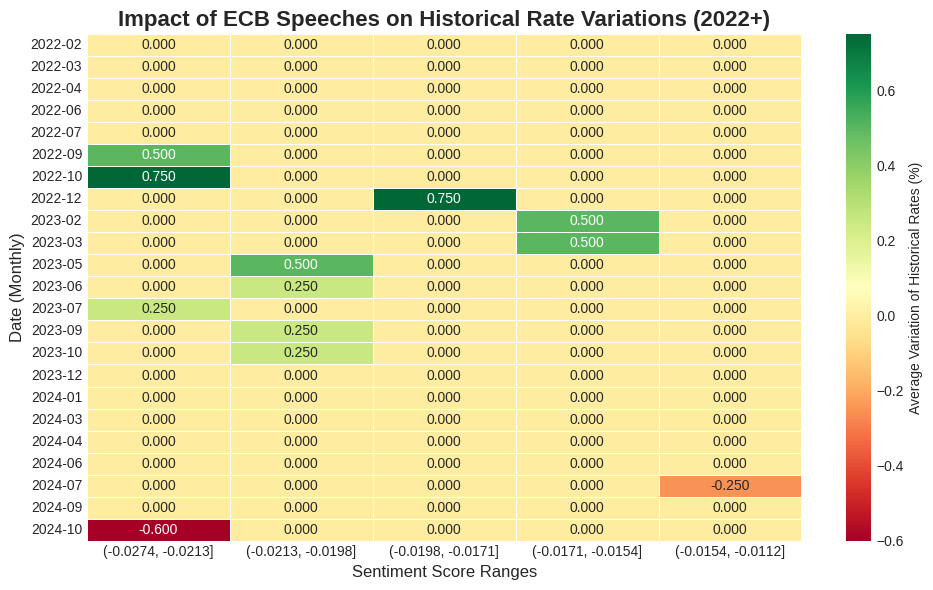

In [ ]:
import seaborn as sns

statements_reset = statements.reset_index().rename(columns={"index": "Date"})
df_historical_rate_2022 = df_historical_rate[df_historical_rate['Date'] >= '2022-01-01']

df_combined = pd.merge(statements_reset, df_historical_rate_2022, on='Date', how='inner')
df_combined['Rate_Change'] = df_combined['Rate'].diff().fillna(0)

sentiment_bins = pd.qcut(df_combined['Sentiment Score'], q=5, duplicates='drop')
df_combined['Sentiment_Category'] = sentiment_bins

df_combined['Month'] = df_combined['Date'].dt.strftime('%Y-%m')
heatmap_data = df_combined.pivot_table(
    values='Rate_Change',
    index='Month',
    columns='Sentiment_Category',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="RdYlGn",
    linewidths=0.5, linecolor="white",
    cbar_kws={'label': 'Average Variation of Historical Rates (%)'}
)

ax.set_xticklabels([str(interval) for interval in heatmap_data.columns], rotation=0, ha="center")

plt.title("Impact of ECB Speeches on Historical Rate Variations (2022+)", fontsize=16, fontweight='bold')
plt.xlabel("Sentiment Score Ranges", fontsize=12)
plt.ylabel("Date (Monthly)", fontsize=12)

plt.tight_layout()
plt.show()

La heatmap montre des variations significatives des taux associées à des discours de la BCE. En particulier, on observe des baisses marquées des taux en septembre et octobre 2022 dans les colonnes où le sentiment score est le plus négatif (environ -0.75 de variation des taux). Cela pourrait indiquer que les discours de cette période, perçus comme très pessimistes, ont coïncidé avec des ajustements de politique monétaire ou des anticipations baissières sur les taux.

De manière générale, on observe qu'il y a plus de variations des taux dans les colonnes où le sentiment score est le plus négatif, tandis que les colonnes associées à des scores plus neutres ou moins extrêmes présentent des variations nulles ou limitées.

En revanche, en septembre 2024, une forte hausse des taux (+0.6) est observée, associé aux sentiments scores les plus négatifs. Cela pourrait refléter un changement de ton dans les discours de la BCE, possiblement interprété comme une réponse aux pressions inflationnistes.

En résumé, les variations des taux semblent particulièrement sensibles aux sentiment scores négatifs, tandis que les discours plus neutres ou modérés génèrent peu d'impact sur les taux.

# 6. Impact des Taux de la BCE sur les Anticipations du Marché et l’EUR/USD

Ici, l’objectif est d’introduire une base de données supplémentaire afin d’évaluer l’impact des taux historiques de la BCE sur les taux de change, en particulier sur l'évolution de l'EUR/USD. Par exemple, une forte augmentation des taux de la BCE (toutes choses égales par ailleurs, notamment les taux de la FED) devrait pousser l’EUR/USD à la hausse en raison de l’attractivité accrue de l’euro, et inversement en cas de baisse des taux.

Source des données pour les taux de change EUR/USD : https://data.ecb.europa.eu/data/datasets/EXR/EXR.D.USD.EUR.SP00.A

In [ ]:
api_url = "https://data-api.ecb.europa.eu/service/data/EXR/D.USD.EUR.SP00.A"
response = requests.get(api_url, headers={"Accept": "application/json"})

if response.status_code == 200:
    data = response.json()

    series = data['dataSets'][0]['series']
    time_periods = data['structure']['dimensions']['observation'][0]['values']

    rows = []
    for key, obs in series.items():
        for obs_key, value in obs['observations'].items():
            date = time_periods[int(obs_key)]['id']
            rate = value[0]
            rows.append({"Date": date, "EUR/USD": rate})

    df_eur_usd = pd.DataFrame(rows)
    df_eur_usd['Date'] = pd.to_datetime(df_eur_usd['Date'])
    df_eur_usd.dropna(inplace=True)

else:
    print(f"ERROR : {response.status_code}")

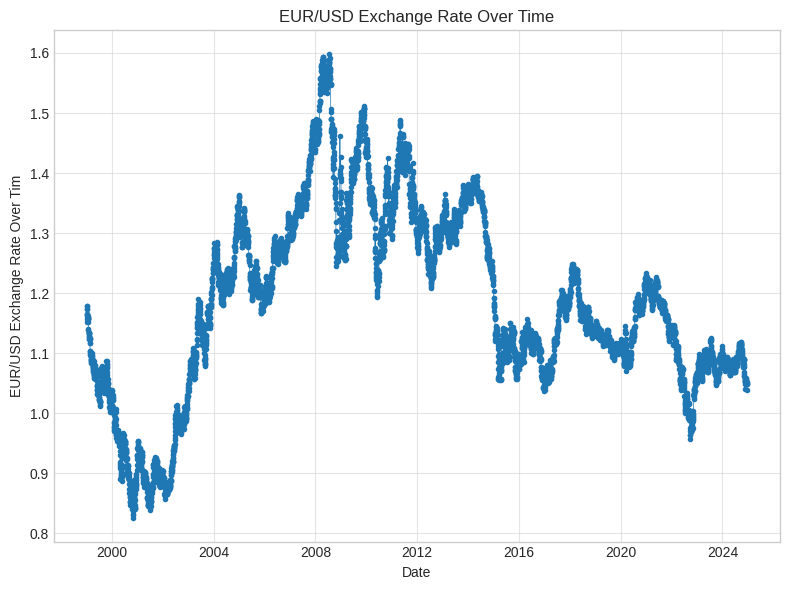

In [ ]:
plt.rcParams['lines.linewidth'] = 0.5
plt.figure(figsize=(8, 6))
plt.plot(df_eur_usd['Date'], df_eur_usd['EUR/USD'],
         marker='o', linestyle='-', linewidth=0.5, markersize=3)

plt.title("EUR/USD Exchange Rate Over Time")
plt.xlabel('Date')
plt.ylabel('EUR/USD Exchange Rate Over Tim')
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

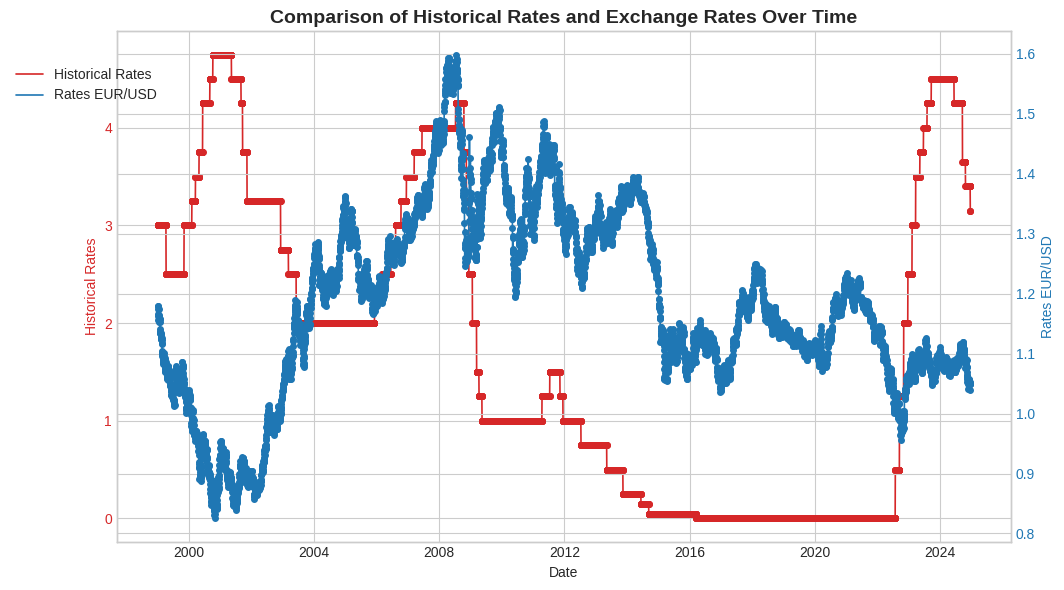

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Historical Rates', color=color)
ax1.plot(df_historical_rate['Date'], df_historical_rate['Rate'], color=color, linestyle='-', linewidth=1.2,
         label='Historical Rates', drawstyle='default')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(df_historical_rate['Date'], df_historical_rate['Rate'], color=color, marker='o', markersize=4, linestyle='None')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Rates EUR/USD', color=color)
ax2.plot(df_eur_usd['Date'], df_eur_usd['EUR/USD'], color=color, linestyle='-', linewidth=1.2,
         label='Rates EUR/USD', drawstyle='default')  # Tracé linéaire lisse
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(df_eur_usd['Date'], df_eur_usd['EUR/USD'], color=color, marker='o', markersize=4, linestyle='None')

plt.title('Comparison of Historical Rates and Exchange Rates Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()

fig.legend(loc="upper right", bbox_to_anchor=(0.1, 0.9), frameon=False)

plt.show()

- Les taux historiques de la BCE (rouge) montrent des changements brusques en réponse aux crises (ex. : baisse rapide en 2008 et maintien à des niveaux bas jusqu'à 2022).
- Le taux EUR/USD (bleu) montre des variations plus progressives et semble réagir avec un léger retard aux changements des taux historiques.
- Les périodes de forte baisse des taux historiques, comme après 2008, coïncident souvent avec une tendance à la baisse du taux EUR/USD, bien qu'il n'y ait pas de corrélation stricte

- Les variations des taux historiques influencent indirectement le taux EUR/USD, mais la relation n'est pas linéaire, car d'autres facteurs (ex. : politique de la Fed, dynamique économique globale) interviennent.
- Une analyse plus approfondie, comme une corrélation ou un modèle de régression, pourrait clarifier le lien entre les deux courbes

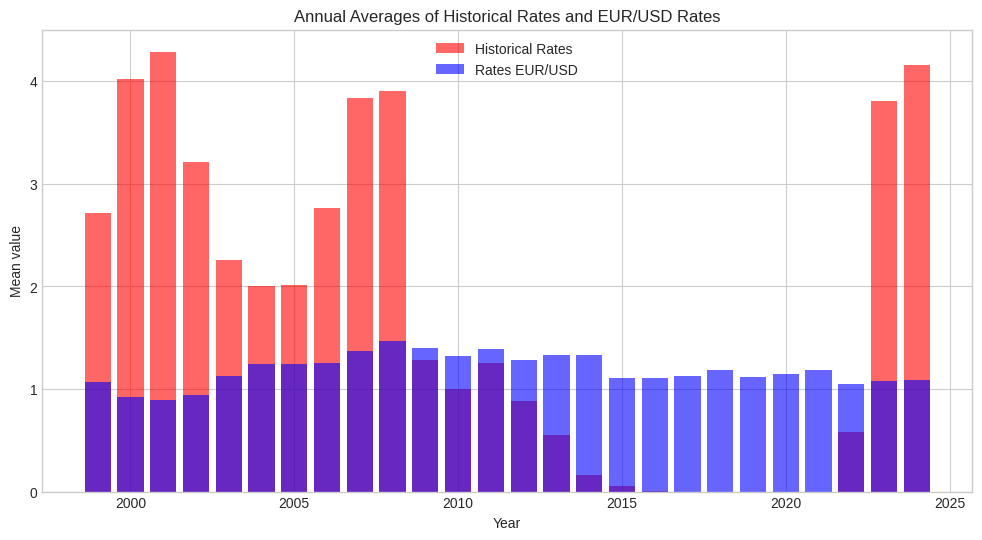

In [ ]:
df_historical_rate['Year'] = df_historical_rate['Date'].dt.year
df_eur_usd['Year'] = df_eur_usd['Date'].dt.year

mean_rate = df_historical_rate.groupby('Year')['Rate'].mean()
mean_eur_usd = df_eur_usd.groupby('Year')['EUR/USD'].mean()

plt.figure(figsize=(12, 6))
plt.bar(mean_rate.index, mean_rate, alpha=0.6, color='red', label='Historical Rates')
plt.bar(mean_eur_usd.index, mean_eur_usd, alpha=0.6, color='blue', label='Rates EUR/USD')
plt.title("Annual Averages of Historical Rates and EUR/USD Rates")
plt.xlabel("Year")
plt.ylabel("Mean value")
plt.legend()
plt.grid(True)
plt.show()

- Les taux historiques de la BCE (rouge) sont élevés au début des années 2000, atteignant un pic avant de diminuer fortement à partir de 2008 en réponse à la crise financière.
- Les moyennes annuelles du taux EUR/USD (violet) sont relativement stables sur la période, mais elles montrent une légère baisse après la crise de 2008.
- Une récente augmentation des taux historiques en 2022-2023 est visible, tandis que le taux EUR/USD reste plus stable.

- Les politiques monétaires de la BCE (taux historiques) sont clairement influencées par des événements macroéconomiques majeurs (crise de 2008, COVID-19, inflation récente).
- Les taux EUR/USD réagissent moins directement aux variations des taux historiques, suggérant qu'ils sont influencés par d'autres facteurs, comme la politique monétaire américaine.

In [ ]:
df_combined = pd.merge(df_historical_rate[['Date', 'Rate']], df_eur_usd[['Date', 'EUR/USD']], on='Date', how='inner')

correlation = df_combined['Rate'].corr(df_combined['EUR/USD'])
print(f"Pearson Correlation Between Historical Rates and EUR/USD Exchange Rates : {correlation:.4f}")

Pearson Correlation Between Historical Rates and EUR/USD Exchange Rates : -0.1971


La corrélation observée est légèrement négative, suggérant qu'une hausse des taux historiques est associée à une baisse modérée du taux EUR/USD. Cela peut refléter une relation inverse entre les taux d'intérêt européens et l'attractivité relative de l'euro par rapport au dollar. Cependant, cette relation reste faible et statistiquement non significative.

Les mouvements du taux EUR/USD sont souvent influencés par une combinaison de facteurs, notamment :
- Le différentiel de taux d'intérêt entre la BCE et la FED, qui ont tendance à adopter des politiques monétaires similaires, ce qui réduit parfois l'impact direct des décisions de l'une ou l'autre sur le taux de change.
- Les niveaux d'inflation et les dynamiques macroéconomiques dans la zone euro et aux États-Unis.
- Les anticipations des marchés financiers, qui intègrent les évolutions prévues des politiques monétaires des deux banques centrales.

Cette interdépendance montre que bien que les décisions de la BCE et de la FED jouent un rôle important, elles s'inscrivent dans un contexte plus large d'interactions économiques globales.

/tmp/ipykernel_17149/2957555421.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rate_Bin', y='EUR/USD', data=rate_summary, palette='viridis')


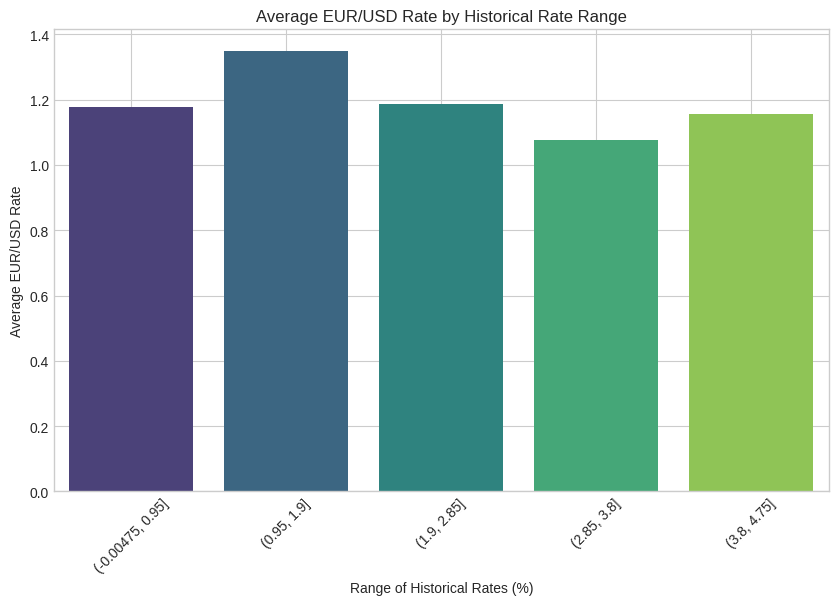

In [ ]:
df_combined['Rate_Bin'] = pd.cut(df_combined['Rate'], bins=5)

rate_summary = df_combined.groupby('Rate_Bin')['EUR/USD'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Rate_Bin', y='EUR/USD', data=rate_summary, palette='viridis')
plt.title("Average EUR/USD Rate by Historical Rate Range")
plt.xlabel("Range of Historical Rates (%)")
plt.ylabel("Average EUR/USD Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Ce graphique montre la moyenne du taux EUR/USD pour différents intervalles de taux historiques. Les taux EUR/USD moyens varient selon les intervalles, avec les plus hauts taux historiques associés à des moyennes légèrement supérieures. Les intervalles intermédiaires affichent des moyennes plus faibles. Cela suggère une corrélation potentielle entre la politique monétaire et la variation des taux de change. Ce type d'analyse peut être utile pour comprendre les dynamiques historiques entre taux d'intérêt et taux de change.

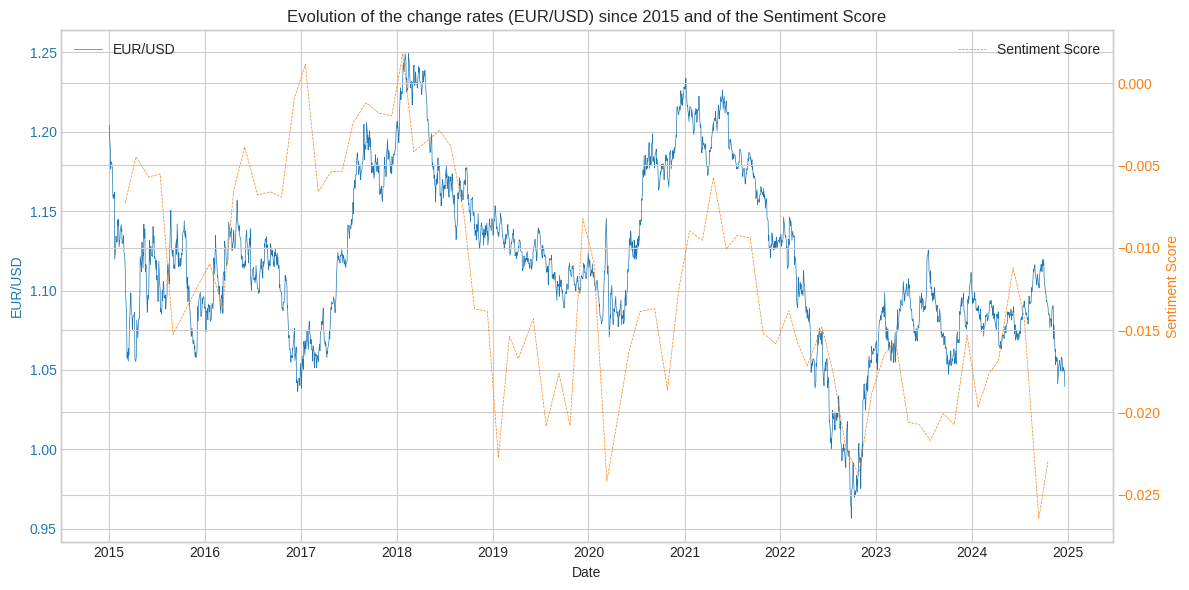

In [ ]:
import matplotlib.pyplot as plt

df_eur_usd_filtered = df_eur_usd[df_eur_usd['Date'] >= '2015-01-01']
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracer le taux de change EUR/USD
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('EUR/USD', color=color)
ax1.plot(df_eur_usd_filtered['Date'], df_eur_usd_filtered['EUR/USD'], color=color, label='EUR/USD')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Tracer le sentiment score
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(statements.index, statements['Sentiment Score'], color=color, linestyle='--', label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title("Evolution of the change rates (EUR/USD) since 2015 and of the Sentiment Score")
fig.tight_layout()
plt.grid(True)
plt.show()

Le graphique présente l'évolution des taux de change EUR/USD (courbe bleue) et du Sentiment Score issu des discours de la BCE (courbe orange) depuis 2015.

Une tendance similaire est perceptible sur le graphe. Les périodes de sentiment fortement négatif semblent coïncider avec des baisses du taux EUR/USD, tandis que des scores plus positifs pourraient stabiliser ou renforcer l'euro.

En effet, comme dit précedemment, un Sentiment Score négatif indique que les discours de la BCE adoptent un ton prudent ou accommodant (dovish).
Lorsque les investisseurs anticipent une politique monétaire accommodante (taux d'intérêt bas), cela réduit l'attractivité de l'euro par rapport au dollar américain.
En conséquence, les flux de capitaux peuvent se diriger vers des devises offrant des rendements plus élevés (comme le dollar si les taux de la FED sont plus élevés). Le taux EUR/USD mesure la valeur de l'euro par rapport au dollar.
Un ton prudent de la BCE peut signaler une faiblesse économique ou des taux bas, ce qui entraîne une baisse de l'EUR/USD.
Cela signifie que l'euro perd de la valeur par rapport au dollar.

In [ ]:
common_dates = statements.index.intersection(df_eur_usd['Date'])
sentiment_score_values = statements.loc[common_dates, 'Sentiment Score']
eur_usd_values = df_eur_usd.set_index('Date').loc[common_dates, 'EUR/USD']
sentiment_score_values = sentiment_score_values.reset_index(drop=True)
eur_usd_values = eur_usd_values.reset_index(drop=True)

# Calculer la corrélation de Pearson
correlation = sentiment_score_values.corr(eur_usd_values)
print(f"Correlation of Pearson between EUR/USD and Sentiment Score : {correlation:.4f}")

Correlation of Pearson between EUR/USD and Sentiment Score : 0.4238


Le coefficient de corrélation Pearson de 0.42 indique une relation positive modérée entre le Sentiment Score et l’EUR/USD : des discours optimistes de la BCE (score élevé) coïncident avec une appréciation de l’euro. Cette corrélation montre un impact partiel du Sentiment Score, mais d'autres facteurs influencent également l’EUR/USD.
Nous allons donc évaluer l'impact du taux d'inflation sur ces taux EUR/USD.

# 7. Ajout et impact du taux d'inflation sur les taux historiques de la BCE ainsi que les taux de change EUR/USD

Nous introduisons le taux d'inflation pour approfondir l'analyse de l'impact des taux historiques sur le taux de change EUR/USD. L'inflation est un facteur clé qui guide les décisions de politique monétaire des banques centrales, notamment la BCE et la FED. En tenant compte de cette variable, nous cherchons à déterminer si elle améliore les résultats de l'analyse en expliquant mieux les variations du taux EUR/USD. Cette approche pourrait révéler des relations plus fortes ou des dynamiques sous-jacentes, en particulier dans le contexte des différentiels de taux d'intérêt influencés par l'inflation.


Source des données pour les taux d'inflation en Europe : https://data.ecb.europa.eu/data/datasets/ICP/ICP.M.U2.N.000000.4.ANR



In [ ]:
url = "https://sdw-wsrest.ecb.europa.eu/service/data/ICP/M.U2.N.000000.4.ANR?format=csvdata"

response = requests.get(url)

if response.status_code == 200:
    csv_data = StringIO(response.text)
    df_icp = pd.read_csv(csv_data, sep=",", encoding="utf-8")

    df_inflation = df_icp[['TIME_PERIOD', 'OBS_VALUE']]
    df_inflation.columns = ['Date', 'Inflation Rate']
    df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])

else:
    print(f"Erreur lors de la récupération des données. Code d'erreur : {response.status_code}")

/tmp/ipykernel_17149/3039238987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])


In [ ]:
df_combined = pd.merge(df_combined, df_inflation, on="Date", how="inner")
df_combined.head()

,Date,Rate,EUR/USD,Rate_Bin,Inflation Rate
0,1999-02-01,3.0,1.1338,"(2.85, 3.8]",0.7
1,1999-03-01,3.0,1.0986,"(2.85, 3.8]",0.9
2,1999-04-01,3.0,1.0772,"(2.85, 3.8]",1.1
3,1999-06-01,2.5,1.0434,"(1.9, 2.85]",0.9
4,1999-07-01,2.5,1.0264,"(1.9, 2.85]",1.0


In [ ]:
correlation = df_combined['Inflation Rate'].corr(df_combined['EUR/USD'])
print(f"Correlation between Inflation and EUR/USD : {correlation:.4f}")

Correlation between Inflation and EUR/USD : -0.1514


La corrélation entre l'inflation et le taux EUR/USD est faiblement négative à -0,1514, suggérant une relation inverse minimale entre les deux variables

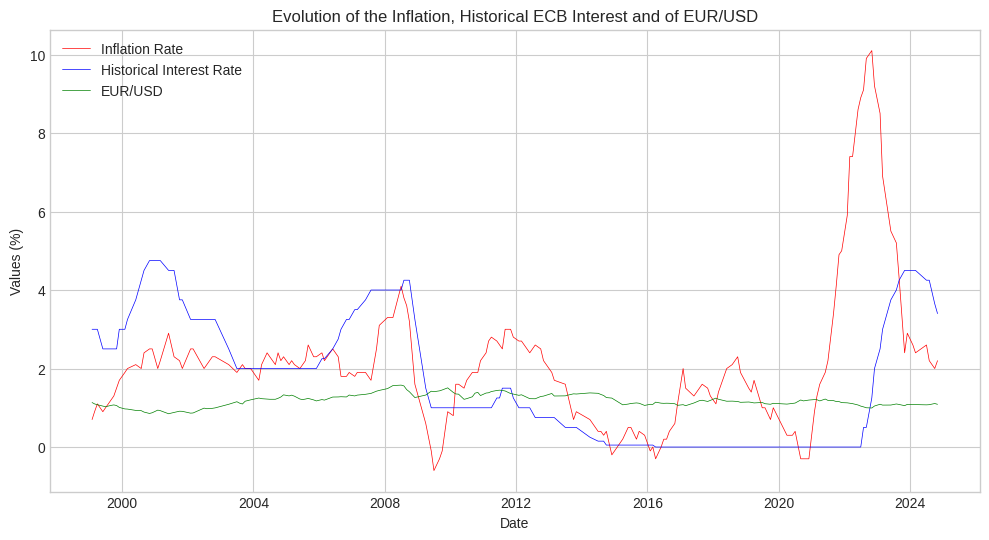

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(df_combined['Date'], df_combined['Inflation Rate'], label='Inflation Rate', color='red')
plt.plot(df_combined['Date'], df_combined['Rate'], label='Historical Interest Rate', color='blue')
plt.plot(df_combined['Date'], df_combined['EUR/USD'], label='EUR/USD', color='green')

plt.title("Evolution of the Inflation, Historical ECB Interest and of EUR/USD")
plt.xlabel("Date")
plt.ylabel("Values (%)")
plt.legend()
plt.grid(True)
plt.show()

Ce graphique montre l'évolution de l'inflation, des taux d'intérêt historiques de la BCE et du taux EUR/USD. On observe que les hausses d'inflation (2022-2023) entraînent des augmentations des taux d'intérêt par la BCE pour la maîtriser. Pendant des périodes comme la crise de 2008, les taux ont été abaissés pour soutenir l'économie. Le taux EUR/USD réagit de manière plus complexe, influencé par des facteurs globaux et les politiques monétaires des deux zones. Sur le graphique, on observe une apparente corrélation entre l'inflation et les taux d'intérêt historiques de la BCE, suggérant que l'inflation pourrait influencer la politique monétaire et, par extension, la valeur de l'euro.

---

Nous allons à présent effectuer une régression afin de prédire le taux de change EUR/USD en fonction des variables explicatives disponibles, telles que les taux d'intérêt et l'inflation.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet

X = df_combined[['Inflation Rate', 'Rate']]
y = df_combined['EUR/USD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

elastic_net = ElasticNet(random_state=42, alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
elastic_net_pred = elastic_net.predict(X_test)
elastic_net_rmse = np.sqrt(mean_squared_error(y_test, elastic_net_pred))
elastic_net_r2 = r2_score(y_test, elastic_net_pred)

comparison = {
    "XGBoost": {"RMSE": xgb_rmse, "R^2": xgb_r2},
    "ElasticNet": {"RMSE": elastic_net_rmse, "R^2": elastic_net_r2},
}

print("Comparison of Models:")
print(comparison)

elastic_net_cv_scores = cross_val_score(elastic_net, X, y, cv=5, scoring='neg_mean_squared_error')
elastic_net_cv_rmse = np.sqrt(-elastic_net_cv_scores).mean()

print(f"\nElasticNet Cross-Validation RMSE: {elastic_net_cv_rmse}")

Comparison of Models:
{'XGBoost': {'RMSE': 0.1048230957610764, 'R^2': 0.6301159232384608}, 'ElasticNet': {'RMSE': 0.1723607408766208, 'R^2': -6.534196504870415e-05}}

ElasticNet Cross-Validation RMSE: 0.18621574184623138


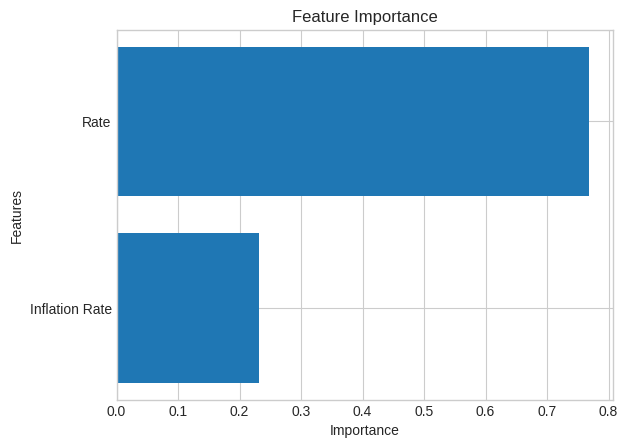

In [ ]:
feature_importance = xgb_model.feature_importances_
plt.barh(X.columns, feature_importance)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

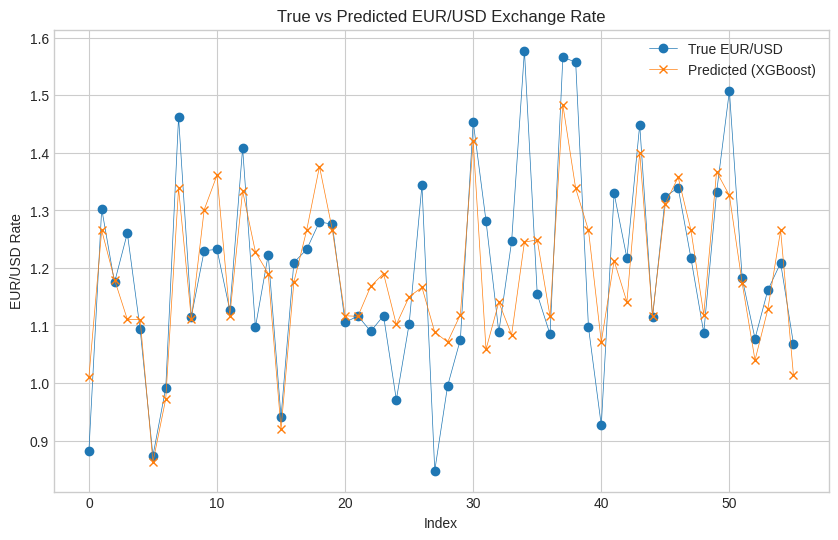

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True EUR/USD", marker='o')
plt.plot(xgb_pred, label=f"Predicted (XGBoost)", marker='x')
plt.title("True vs Predicted EUR/USD Exchange Rate")
plt.xlabel("Index")
plt.ylabel("EUR/USD Rate")
plt.legend()
plt.show()

**Intégration du Score de Sentiment dans la Régression**

Nous allons tenter d'ajouter le **Score de Sentiment** comme variable explicative à notre régression. Cela permettra d'évaluer si les émotions capturées par ce score ont un impact significatif sur la variable cible.


In [ ]:
df_combined['Date'] = pd.to_datetime(df_combined['Date'])
statements.index = pd.to_datetime(statements.index)

sentiment_scores = statements[['Sentiment Score']].reset_index()

df_sentiment_reg = df_combined.merge(sentiment_scores, how='left', on='Date')
df_sentiment_reg['Sentiment Score'] = df_sentiment_reg['Sentiment Score'].interpolate(method='linear')

df_sentiment_reg = df_sentiment_reg.dropna().set_index('Date')

In [ ]:
df_sentiment_reg.head()

,Rate,EUR/USD,Rate_Bin,Inflation Rate,Sentiment Score
Date,,,,,
2016-06-01,0.0,1.1174,"(-0.00475, 0.95]",0.0,-0.003877
2016-07-01,0.0,1.1135,"(-0.00475, 0.95]",0.2,-0.004129
2016-08-01,0.0,1.1164,"(-0.00475, 0.95]",0.2,-0.004380
2016-09-01,0.0,1.1146,"(-0.00475, 0.95]",0.4,-0.004632
2016-11-01,0.0,1.1025,"(-0.00475, 0.95]",0.6,-0.004884


In [ ]:
# Add Sentiment Score as an explanatory variable
X_sentiment = df_sentiment_reg[['Inflation Rate', 'Rate', 'Sentiment Score']]
y_sentiment = df_sentiment_reg['EUR/USD']

X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    X_sentiment, y_sentiment, test_size=0.3, random_state=42
)

# XGBoost model with Sentiment
xgb_model_sentiment = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model_sentiment.fit(X_train_sentiment, y_train_sentiment)
xgb_pred_sentiment = xgb_model_sentiment.predict(X_test_sentiment)
xgb_rmse_sentiment = np.sqrt(mean_squared_error(y_test_sentiment, xgb_pred_sentiment))
xgb_r2_sentiment = r2_score(y_test_sentiment, xgb_pred_sentiment)

# ElasticNet model with Sentiment
elastic_net_sentiment = ElasticNet(random_state=42, alpha=0.1, l1_ratio=0.5)
elastic_net_sentiment.fit(X_train_sentiment, y_train_sentiment)
elastic_net_pred_sentiment = elastic_net_sentiment.predict(X_test_sentiment)
elastic_net_rmse_sentiment = np.sqrt(mean_squared_error(y_test_sentiment, elastic_net_pred_sentiment))
elastic_net_r2_sentiment = r2_score(y_test_sentiment, elastic_net_pred_sentiment)

comparison_sentiment = {
    "XGBoost with Sentiment": {"RMSE": xgb_rmse_sentiment, "R^2": xgb_r2_sentiment},
    "ElasticNet with Sentiment": {"RMSE": elastic_net_rmse_sentiment, "R^2": elastic_net_r2_sentiment},
}

elastic_net_cv_scores_sentiment = cross_val_score(
    elastic_net_sentiment, X_sentiment, y_sentiment, cv=5, scoring='neg_mean_squared_error'
)
elastic_net_cv_rmse_sentiment = np.sqrt(-elastic_net_cv_scores_sentiment).mean()

comparison_sentiment["ElasticNet with Sentiment"]["Cross-Validation RMSE"] = elastic_net_cv_rmse_sentiment

print("Comparison of Models with Sentiment:")
print(comparison_sentiment)

print(f"\nElasticNet with Sentiment Cross-Validation RMSE: {elastic_net_cv_rmse_sentiment}")

Comparison of Models with Sentiment:
{'XGBoost with Sentiment': {'RMSE': 0.024687947426599615, 'R^2': 0.8313403141113197}, 'ElasticNet with Sentiment': {'RMSE': 0.05432600636798109, 'R^2': 0.18331067336711493, 'Cross-Validation RMSE': 0.05815498086105042}}

ElasticNet with Sentiment Cross-Validation RMSE: 0.05815498086105042


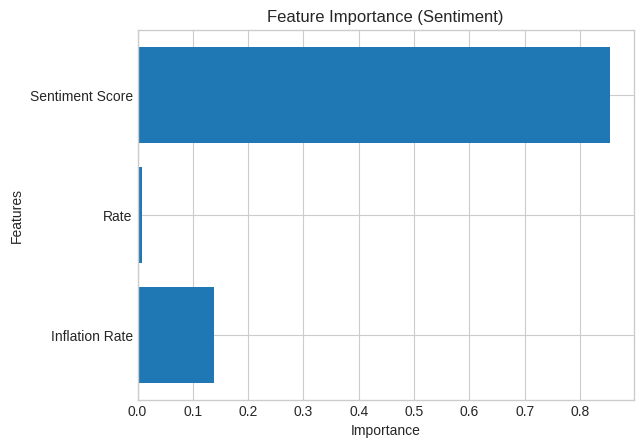

In [ ]:
feature_importance_sentiment = xgb_model_sentiment.feature_importances_
plt.barh(X_sentiment.columns, feature_importance_sentiment)
plt.title("Feature Importance (Sentiment)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

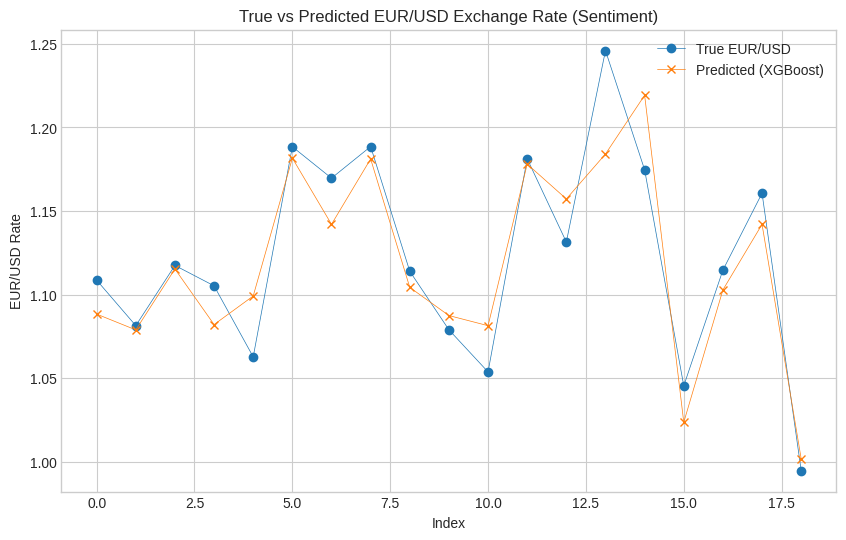

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_sentiment.values, label="True EUR/USD", marker='o')
plt.plot(xgb_pred_sentiment, label=f"Predicted (XGBoost)", marker='x')
plt.title("True vs Predicted EUR/USD Exchange Rate (Sentiment)")
plt.xlabel("Index")
plt.ylabel("EUR/USD Rate")
plt.legend()
plt.show()

---

**Analyse des résultats des modèles**

Deux configurations de modèles ont été testées pour prédire le taux de change EUR/USD :
- **Sans Sentiments** : Variables explicatives limitées au taux d'intérêt (**Rate**) et au taux d'inflation (**Inflation Rate**).
- **Avec Sentiments** : Ajout du **Score de Sentiment** comme variable explicative, dérivé de l'analyse des déclarations monétaires.

Les modèles utilisés pour les deux configurations sont :
- **XGBoost** : Modèle basé sur des arbres de décision, capable de capturer des relations complexes.
- **ElasticNet** : Régression linéaire régularisée, adaptée pour des données multicolinéaires.

**Performances des modèles**

**Sans Sentiments**
- **XGBoost**
  - **RMSE** : 0.1048
  - **R²** : 0.6301  
    Indique que 63 % de la variance des données est expliquée, montrant que XGBoost capture efficacement les relations complexes entre les variables.
- **ElasticNet**
  - **RMSE** : 0.1724
  - **R²** : -0.00007  
    Performances très faibles, suggérant une inadéquation avec les hypothèses de linéarité du modèle.

**Avec Sentiments**
- **XGBoost**
  - **RMSE** : 0.0247
  - **R²** : 0.8313  
    Une nette amélioration, avec 83 % de la variance expliquée. L'ajout des sentiments enrichit le modèle de manière significative.
- **ElasticNet**
  - Performances similaires à celles obtenues sans sentiments, confirmant que le modèle ne capture pas efficacement les relations complexes.

**Importance des variables dans XGBoost**

- **Score de Sentiment** : **85,4 %**  
  C'est la variable dominante, indiquant que les signaux émotionnels capturés dans les déclarations monétaires jouent un rôle crucial pour expliquer le taux de change EUR/USD.
- **Taux d'inflation (Inflation Rate)** : **13,8 %**  
  Une influence notable mais bien inférieure à celle des sentiments.
- **Taux d'intérêt historique (Rate)** : **0,8 %**  
  Contribution négligeable, ce qui suggère que les variations historiques des taux d'intérêt sont moins explicatives dans ce contexte.

**Interprétation des résultats**

- **Rôle des sentiments**
  - Le **Score de Sentiment** émerge comme la variable la plus influente dans le modèle avec XGBoost, expliquant en grande partie la performance améliorée.
  - Cela reflète l'importance des signaux textuels et émotionnels dans les déclarations monétaires pour anticiper les mouvements du taux de change.
- **Diminution de l'importance des autres variables**
  - Le rôle des **taux d'intérêt historiques** devient négligeable avec l'ajout des sentiments, probablement car ces derniers capturent des signaux plus immédiats et dynamiques.
  - L'influence de l'**inflation** reste pertinente, mais elle est reléguée au second plan.

**Limites et perspectives**

- **Perte de données historiques**
  - L'ajout du **Score de Sentiment** entraîne une perte des données entre 1999 et 2015, limitant la taille de l'ensemble d'entraînement.
  - Cette contrainte réduit la capacité du modèle à capturer des tendances long terme.

- **Opportunités futures**
  - Étendre la couverture temporelle des Scores de Sentiment permettrait d'exploiter davantage les données historiques.
  - Enrichir le modèle avec des variables supplémentaires, comme des indicateurs économiques US, pourrait également renforcer la robustesse des prédictions.

En conclusion, l'ajout des sentiments a démontré son potentiel pour expliquer le taux de change EUR/USD, avec une performance nettement améliorée dans le modèle XGBoost. Cependant, la disponibilité limitée des données de sentiment reste une contrainte majeure à surmonter pour maximiser leur valeur explicative.

# Conclusion


Cette analyse visait à comprendre l’impact des décisions de politique monétaire de la BCE sur les taux EUR/USD et les taux d’intérêt historiques, tout en explorant le rôle des discours officiels de la BCE à travers un **Sentiment Score**.

**1. Pertinence du Sentiment Score**  
Le Sentiment Score, calculé à partir des discours de la BCE, s’est révélé un indicateur significatif dans le modèle XGBoost, avec une importance de **85,4 %** dans l’explication des variations du taux EUR/USD. Cela indique que la tonalité des discours officiels joue un rôle crucial dans les anticipations des marchés financiers. Une tendance similaire a également été observée : des scores négatifs sont souvent associés à une dépréciation de l’euro, tandis que des scores plus optimistes tendent à stabiliser ou renforcer sa valeur. Cette dynamique montre que la tonalité des discours influence la perception des marchés financiers, bien que son effet reste partiel et modulé par d’autres facteurs globaux.

Pour les taux d’intérêt historiques, le Sentiment Score semble jouer un rôle dans l’anticipation des marchés. À partir de 2022, une hausse marquée des taux d’intérêt de la BCE coïncide avec un Sentiment Score généralement négatif, reflétant une communication prudente dans un contexte de forte inflation. Les variations du Sentiment Score précèdent légèrement les décisions de la BCE, suggérant que les discours officiels influencent les attentes des marchés avant l’annonce des politiques.

Cependant, la disponibilité limitée des données de sentiments (uniquement à partir de 2015) représente une contrainte majeure. Cette restriction exclut une période importante entre 1999 et 2015, ce qui réduit la capacité du modèle à capturer des tendances à long terme. Augmenter la couverture temporelle des Scores de Sentiment, en les générant pour les discours plus anciens, pourrait considérablement améliorer les performances du modèle.

**2. Impact des Taux d’Intérêt sur l’EUR/USD**  
Les taux d’intérêt historiques de la BCE ont une importance limitée dans le modèle XGBoost avec une pondération de **0,8 %**, en raison de l’influence dominante des sentiments. Cette faible importance pourrait indiquer que les signaux émotionnels capturés par le Sentiment Score englobent en partie les effets des taux d’intérêt historiques sur l’EUR/USD. Toutefois, leur relation avec le taux de change reste légèrement négative, suggérant qu’une hausse des taux européens peut réduire l’attractivité de l’euro par rapport au dollar, en raison du différentiel de rendement avec les taux américains.

**3. Interaction entre l’Inflation et les Taux**  
L’inflation influence directement les décisions de la BCE. Une forte corrélation est observée entre les hausses de l’inflation et les augmentations des taux d’intérêt, notamment depuis 2022. Cette dynamique confirme que la BCE ajuste sa politique monétaire pour maîtriser les pressions inflationnistes, ce qui a un impact indirect sur la valeur de l’euro. Dans XGBoost, l’inflation est la seconde variable la plus importante, avec une pondération de **13,8 %**, soulignant son rôle complémentaire.

**4. Une Influence Complexe et Globale**  
Les résultats montrent que bien que les annonces et décisions de la BCE soient des facteurs clés, le taux EUR/USD reste influencé par un ensemble plus vaste d’interactions globales :  
- Le différentiel de taux d’intérêt entre la BCE et la Fed.  
- Les niveaux d’inflation relatifs entre les deux économies.  
- Les anticipations des marchés financiers, qui intègrent les perspectives économiques des deux zones.

\

En conclusion, bien que le Sentiment Score reflète partiellement les mouvements des taux et des marchés, il s’inscrit dans une dynamique plus large où les décisions de la BCE interagissent avec d’autres forces économiques globales. XGBoost, en capturant ces interactions complexes, s’affirme comme un outil performant pour modéliser ces relations. Toutefois, l’amélioration de la disponibilité et de la qualité des données de sentiments pourrait encore renforcer la précision et la robustesse des modèles.